# Cats vs Dogs Classification

In this notebook, you will not only learn about how to build a model to classify Cats and Dogs but also how the Preprocessing and Dropout will improve your model while training and produce a better network.

# Import Libraries

## Install Tensorflow 2

If Tensorflow 2 is not already installed, install it first.

In [0]:
!pip install tensorflow-gpu -q

In [2]:
import tensorflow as tf

tf.__version__


'2.1.0'

## Import other libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model

np.set_printoptions(precision=7)
np.random.seed(42)
%matplotlib inline

# Tensorflow Dataset

This notebook uses cats_vs_dogs data from Tensorflow dataset, you can see the details here https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

## Create directory for dataset

In [0]:
import os

data_dir = 'dataset'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)

## Download Cats vs Dogs dataset

In [0]:
dataset_name = 'cats_vs_dogs'

train_set, dataset_info =  tfds.load( 
              name = dataset_name, 
              split = 'train', 
              with_info = True, 
              data_dir = data_dir
          )

## Dataset Information

In [6]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

## Detailed Information

In [7]:
class_names =  dataset_info.features["label"].names

print('image shape    :', dataset_info.features['image'].shape)
print('image dtype    :', dataset_info.features['image'].dtype)
print()
print('num class      : ',dataset_info.features["label"].num_classes)
print('class label    :', dataset_info.features["label"].names)
print()
print('num train data :', dataset_info.splits["train"].num_examples)

image shape    : (None, None, 3)
image dtype    : <dtype: 'uint8'>

num class      :  2
class label    : ['cat', 'dog']

num train data : 23262


## Show images

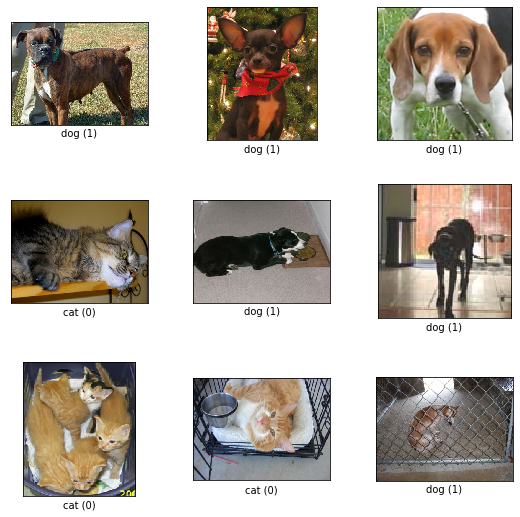

In [8]:
fig = tfds.show_examples(dataset_info, train_set)

As we can see, the image sizes differ from one another, so we have to resize all the images to the same size.

# Preprocess Image

Convert and Resize Data

In [0]:
input_shape = (128, 128, 3)

## Convert Data Train

In [0]:
X_train_ori = []
y_train_ori = []

for example in tfds.as_numpy(train_set):
    new_img = example['image']
    new_img = cv.resize(new_img, input_shape[:2],interpolation = cv.INTER_AREA) 
    X_train_ori.append(new_img)
    y_train_ori.append(example['label'])

del train_set

# Convert train data to numpy array
X_train_ori = np.asarray(X_train_ori)
y_train_ori = np.asarray(y_train_ori)

# One hot label
y_train_hot = to_categorical(y_train_ori)

# Split Train Data into Train, Val, and Test

In [11]:
# Set the length of Train, Val, and Test data
dataset_size = len(X_train_ori)
train_idx = int(0.7 * dataset_size)
val_idx = int(0.1 * dataset_size) + train_idx

# Split for val data
X_val = X_train_ori[train_idx:val_idx, :]
y_val = y_train_hot[train_idx:val_idx]

# Split for test data
X_test = X_train_ori[val_idx:, :]
y_test = y_train_hot[val_idx:]

# Split for train data
X_train = X_train_ori[:train_idx, :]
y_train = y_train_hot[:train_idx]

print('X_train.shape =',X_train.shape)
print('X_val.shape =',X_val.shape)
print('X_test.shape =',X_test.shape)

print('y_train.shape =',y_train.shape)
print('y_val.shape =',y_val.shape)
print('y_test.shape =',y_test.shape)

X_train.shape = (16283, 128, 128, 3)
X_val.shape = (2326, 128, 128, 3)
X_test.shape = (4653, 128, 128, 3)
y_train.shape = (16283, 2)
y_val.shape = (2326, 2)
y_test.shape = (4653, 2)


# Classification Model

In [12]:
model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),    
    Dense(units=2, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [13]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = []

his = model1.fit(X_train, y_train, batch_size=512, epochs=15, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/15
16283/16283 [==============================] - 14s 854us/sample - loss: 11.3353 - accuracy: 0.5141 - val_loss: 0.6653 - val_accuracy: 0.5881
Epoch 2/15
16283/16283 [==============================] - 9s 553us/sample - loss: 0.6401 - accuracy: 0.6297 - val_loss: 0.6053 - val_accuracy: 0.6724
Epoch 3/15
16283/16283 [==============================] - 9s 552us/sample - loss: 0.5825 - accuracy: 0.6898 - val_loss: 0.5727 - val_accuracy: 0.6935
Epoch 4/15
16283/16283 [==============================] - 9s 552us/sample - loss: 0.5254 - accuracy: 0.7351 - val_loss: 0.5594 - val_accuracy: 0.7098
Epoch 5/15
16283/16283 [==============================] - 9s 553us/sample - loss: 0.4724 - accuracy: 0.7678 - val_loss: 0.5610 - val_accuracy: 0.7330
Epoch 6/15
16283/16283 [==============================] - 9s 552us/sample - loss: 0.4114 - accuracy: 0.8083 - val_loss: 0.5659 - val_accuracy: 0.7257
Epoch 7/15
16283/16283 [=========================

Looks pretty good, right? In just 10 epochs we've got ~90% of train accuracy

But why the validation loss getting bigger and the validation accuracy not increasing?

Yeah, this is what we called overfitting.

# Overfitting Challenge

Overfitting is a problem in machine learning in general, not just in neural networks. The problem is inherent in the way machine learning models are developed: A set of "training data" is used to "train" the model. The goal is to have a model that can then be used on data that hasn't been seen before. Over-fitting refers to the problem of having the model trained to work so well on the training data that it starts to work more poorly on data it hasn't seen before.

![Overfitting](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-03-at-7.52.01-PM-e1522832332857.png)

![alt text](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-04-at-2.43.37-PM-768x592.png)

There are some techniques to prevent overfitting:
* Add more data
* use Data Augmentation
* use Batch Normalization & Standardization
* use Dropout
* use architecture that generalize well
* reduce architecture complexity
* Early stopping

source : http://primo.ai/index.php?title=Overfitting_Challenge

Let's add some Dropout to our network!

In [14]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 128)      

In [15]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model2.fit(X_train, y_train, batch_size=512, epochs=15, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/15
16283/16283 [==============================] - 13s 784us/sample - loss: 1.9080 - accuracy: 0.4986 - val_loss: 0.6928 - val_accuracy: 0.5009
Epoch 2/15
16283/16283 [==============================] - 11s 671us/sample - loss: 0.6927 - accuracy: 0.5030 - val_loss: 0.6914 - val_accuracy: 0.5064
Epoch 3/15
16283/16283 [==============================] - 11s 669us/sample - loss: 0.6927 - accuracy: 0.5137 - val_loss: 0.6902 - val_accuracy: 0.5447
Epoch 4/15
16283/16283 [==============================] - 11s 669us/sample - loss: 0.6914 - accuracy: 0.5182 - val_loss: 0.6910 - val_accuracy: 0.5241
Epoch 5/15
16283/16283 [==============================] - 11s 671us/sample - loss: 0.6881 - accuracy: 0.5268 - val_loss: 0.6761 - val_accuracy: 0.5795
Epoch 6/15
16283/16283 [==============================] - 11s 669us/sample - loss: 0.6802 - accuracy: 0.5621 - val_loss: 0.6762 - val_accuracy: 0.5628
Epoch 7/15
16283/16283 [=====================

After adding some Dropout to our network, now the model is not overfit. So, what is Dropout? How can it handle the overfitting?

# Dropout

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. The key idea is to randomly drop units (along with their connections) from the neural network during training

![alt text](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

source : http://primo.ai/index.php?title=Dropout

The network performance is really good as it got ~80% of accuracy. But actually we can make the network convergence faster than this.

How about normalize the data? Would it help the model to convergence faster? We'll see it.

# Normalize Data

In [0]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train = ((X_train - mean_pixel) / std_pixel).astype('float32')

X_val = ((X_val - mean_pixel) / std_pixel).astype('float32')

X_test = ((X_test - mean_pixel) / std_pixel).astype('float32')

Re-define the model

In [17]:
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 31, 128)      

In [18]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model3.fit(X_train, y_train, batch_size=512, epochs=15, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/15
16283/16283 [==============================] - 12s 755us/sample - loss: 0.6987 - accuracy: 0.5115 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/15
16283/16283 [==============================] - 12s 717us/sample - loss: 0.6839 - accuracy: 0.5386 - val_loss: 0.6477 - val_accuracy: 0.6152
Epoch 3/15
16283/16283 [==============================] - 12s 717us/sample - loss: 0.6455 - accuracy: 0.6261 - val_loss: 0.6059 - val_accuracy: 0.6801
Epoch 4/15
16283/16283 [==============================] - 12s 718us/sample - loss: 0.6024 - accuracy: 0.6787 - val_loss: 0.5533 - val_accuracy: 0.7253
Epoch 5/15
16283/16283 [==============================] - 12s 717us/sample - loss: 0.5535 - accuracy: 0.7325 - val_loss: 0.5066 - val_accuracy: 0.7506
Epoch 6/15
16283/16283 [==============================] - 12s 716us/sample - loss: 0.5110 - accuracy: 0.7629 - val_loss: 0.4514 - val_accuracy: 0.7863
Epoch 7/15
16283/16283 [=====================

Let's see the training accuracy and loss for our three models!

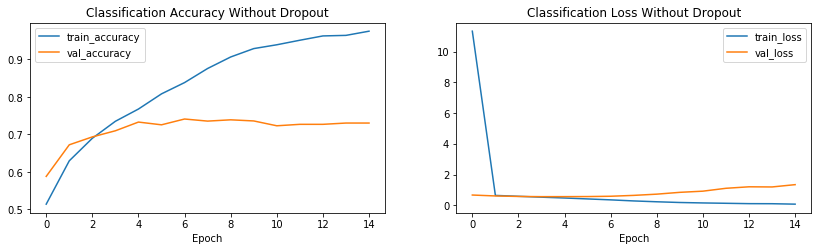

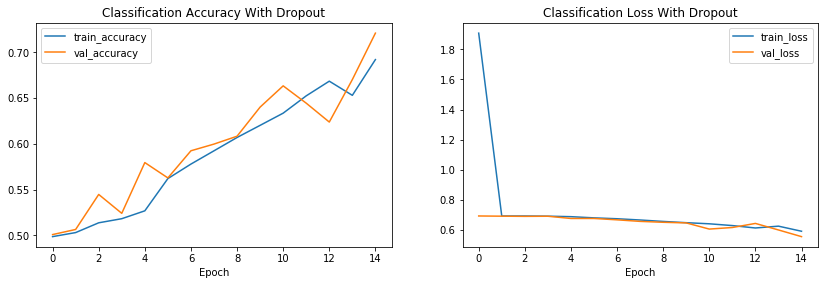

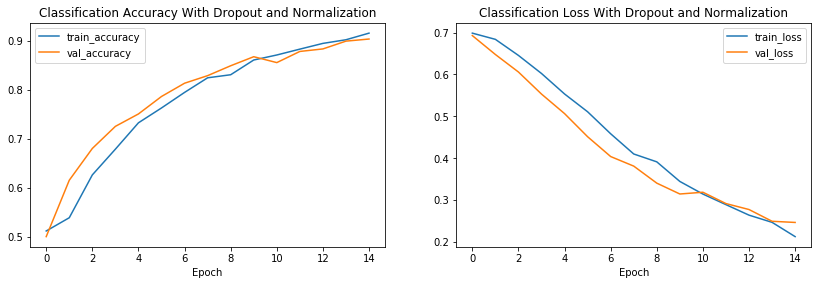

In [19]:
model_name = ["Without Dropout", "With Dropout", "With Dropout and Normalization"]

plt.rcParams['figure.figsize'] = [14, 14]
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, name in enumerate(model_name):
  plt.subplot(3, 2, i*2+1)
  plt.plot(history[i].history['accuracy'], label='train_accuracy')
  plt.plot(history[i].history['val_accuracy'], label='val_accuracy')
  plt.title("Classification Accuracy " + model_name[i])
  plt.xlabel('Epoch')
  plt.legend()

  plt.subplot(3, 2, i*2+2)
  plt.plot(history[i].history['loss'], label='train_loss')
  plt.plot(history[i].history['val_loss'], label='val_loss')
  plt.title("Classification Loss " + model_name[i])
  plt.xlabel('Epoch')
  plt.legend()
  
  plt.show()


As we can see, the network that trained with Normalized data convergence faster than the other. Also, the loss start from ~70% and become ~30% at the end of training while the other model loss start with 3x bigger than what it should be. So, what Data Normalization is?

# Data Normalization

In the simplest cases, normalization means adjusting values on different scales to a common scale. In more complicated cases, normalization may refer to more sophisticated adjustments where the intention is to bring the entire probability distributions of adjusted values into alignment. In the case of normalization of scores in educational assessment, there may be an intention to align distributions to a normal distribution.

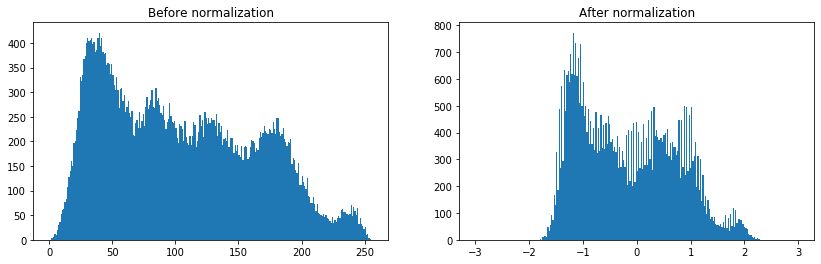

In [20]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(121)
plt.hist(X_train_ori[0].ravel(),256,[0,256])
plt.title("Before normalization")

plt.subplot(122)
plt.hist(X_train[0].ravel(),256,[-3,3])
plt.title("After normalization")
plt.show()

To use numeric data for machine regression, you usually need to normalize the data. Otherwise, the numbers with larger ranges may tend to dominate the Euclidian distance between feature vectors, their effects can be magnified at the expense of the other fields, and the steepest descent optimization may have difficulty converging. There are a number of ways to normalize and standardize data for ML, including min-max normalization, mean normalization, standardization, and scaling to unit length. This process is often called feature scaling.

Normalization / Standardization is beneficial in many cases. It improves the numerical stability of the model and often reduces training time. However, standardization isn’t always great. It can harm the performance of distance-based clustering algorithms by assuming equal importance of features. If there are inherent importance differences between features, it’s generally not a good idea to do standardization.

# Evaluate Model

## Model Performance Without Dropout

In [21]:
train_scores = model1.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model1.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model1.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 1s 384us/sample - loss: 7.2175 - accuracy: 0.4987
Train Loss: 7.23289 with Accuracy: 50.2%
Test  Loss: 7.46253 with Accuracy: 50.4%
Val   Loss: 7.21753 with Accuracy: 49.9%


## Model Performance With Dropout

In [22]:
train_scores = model2.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model2.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model2.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 1s 413us/sample - loss: 3.6672 - accuracy: 0.5000
Train Loss: 3.66212 with Accuracy: 50.1%
Test  Loss: 3.62156 with Accuracy: 50.4%
Val   Loss: 3.66721 with Accuracy: 50.0%


## Model Performance With Dropout and Data Normalization

In [23]:
train_scores = model3.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model3.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model3.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 1s 417us/sample - loss: 0.2468 - accuracy: 0.9037
Train Loss: 0.14436 with Accuracy: 94.2%
Test  Loss: 0.27446 with Accuracy: 89.2%
Val   Loss: 0.24683 with Accuracy: 90.4%


Today you have learn about the use of preprocessing and Dropout. Next, we will learn how Batch Normalization help the network to convergence

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/malikanhar/>2019 - MALIK</a> </p>